# Data Cleaning
### Table of Contents
- [Requirements](#requirements)
- [Visualizing Missingness](#visualizing-missingness)
  - [By Variable](#by-variable)
  - [By Year Per State](#by-year-per-state)
- [Dataset Cleaning](#dataset-cleaning)
- [Effects on the Data](#effects-on-the-Data)

## Requirements

In [64]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

## Visualizing Missingness

In [65]:
# reading the raw, integrated dataset

df = pd.read_csv('../../data/raw/integrated.csv') # file path appears as `data/raw/integrated.csv` in `cleaning.py`

df_1866_2024 = df.copy()

### By Variable

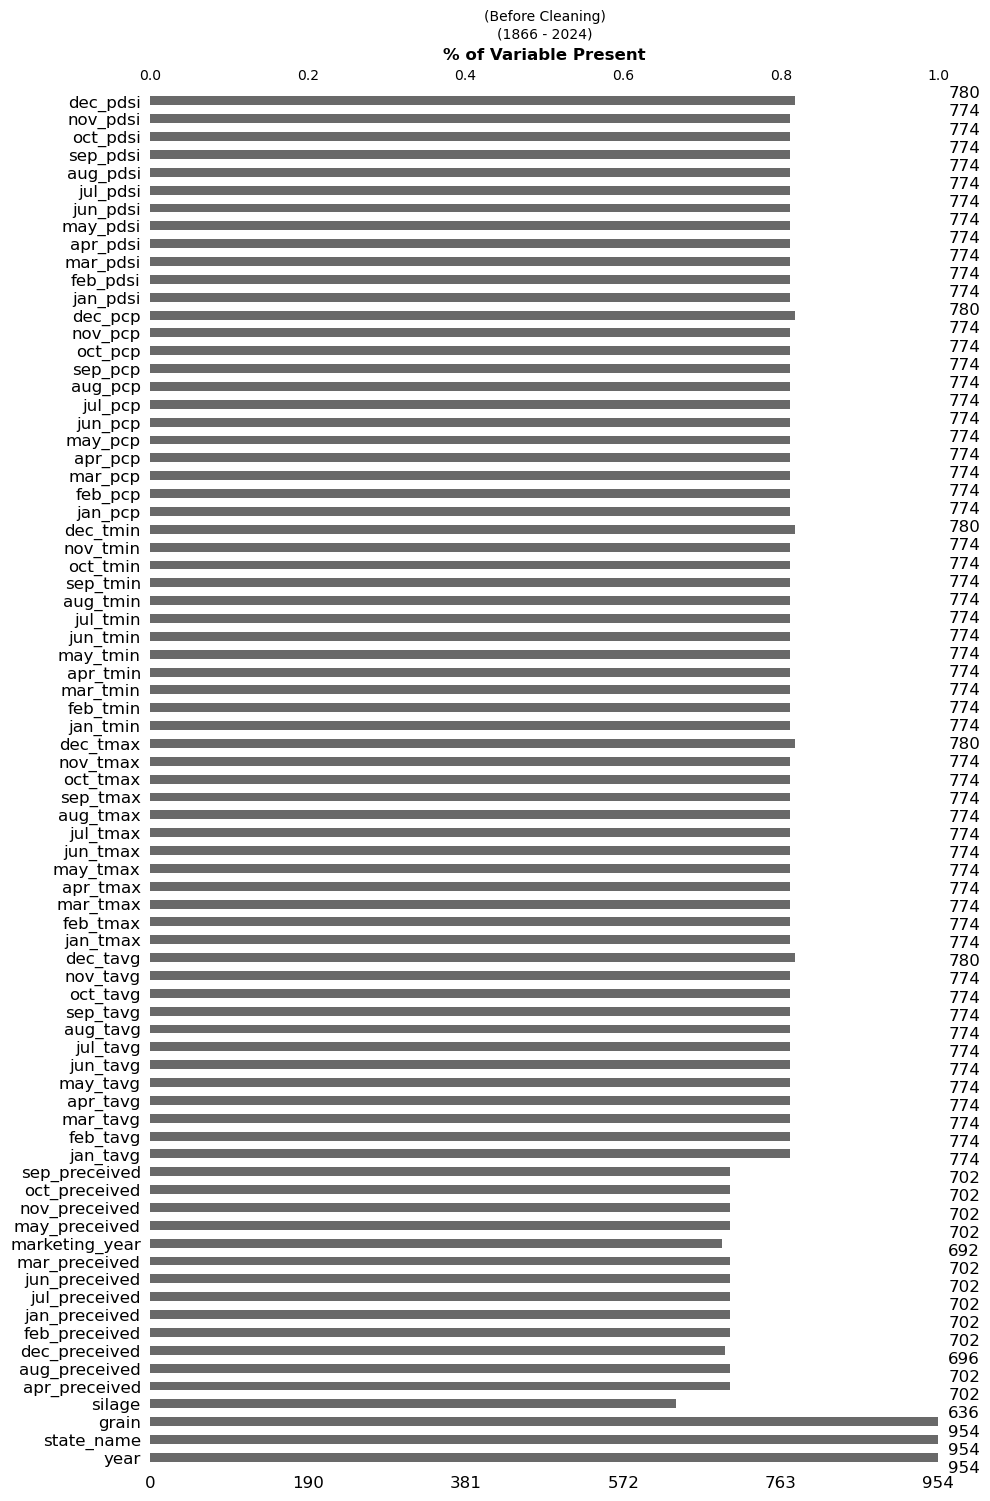

In [66]:
# visualizing the percentage of each variable that is *NOT* NaN before data cleaning

msno.bar(
    df_1866_2024,
    figsize=(10, 15),
    fontsize=12
)
plt.title('% of Variable Present', fontweight='bold')
plt.text(
    0.5, 80.5,
    f'(Before Cleaning)',
    horizontalalignment='center'
)
plt.text(
    0.5, 79.5,
    f'(1866 - 2024)',
    horizontalalignment='center'
)
plt.tight_layout()
plt.savefig(
    f'../../results/cleaning/raw_msno_bar.png' # file path appears as `results/cleaning/raw_msno_bar.png` in `cleaning.py`
)
plt.show()

### By Year Per State

In [67]:
# finding the total NaN by year per state (by record)

df_missing = df_1866_2024.set_index(['year', 'state_name']).isna()
df_missing.replace(to_replace=True, value=1, inplace=True)
df_missing.replace(to_replace=False, value=0, inplace=True)
df_missing.reset_index(inplace=True)

df_missing['nan_total'] = df_missing.iloc[:,2:].sum(axis=1)

/var/folders/j7/fswh0x992tzfxgs898w7vv9w0000gn/T/ipykernel_16393/3215284954.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_missing.replace(to_replace=False, value=0, inplace=True)


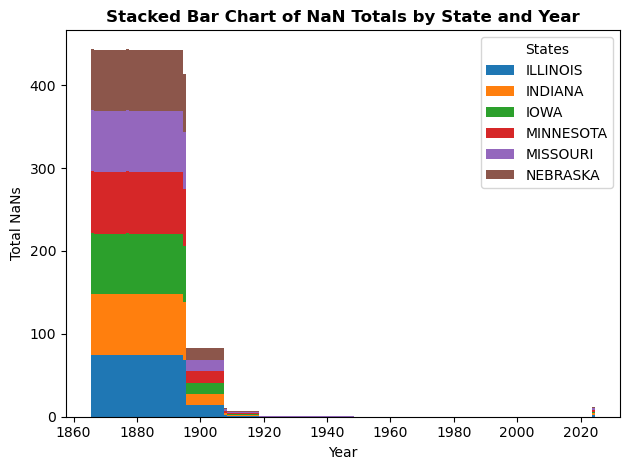

In [68]:
# visualizing the total number of NaN by year per state (by record)

states = list(df_missing['state_name'].unique())
bottom = 0
fig, ax = plt.subplots()

for i, state in enumerate(states):

    df_temp = df_missing[df_missing['state_name'] == state]
    years = df_temp['year'].values
    
    ax.bar(
        x=years,
        height=df_temp['nan_total'],
        label=state,
        width=1,
        bottom=bottom
    )
    
    bottom += df_temp['nan_total'].values

ax.set_xlabel('Year')
ax.set_ylabel('Total NaNs')
ax.legend(title='States')
ax.set_title('Stacked Bar Chart of NaN Totals by State and Year', fontweight='bold')

plt.tight_layout()
plt.savefig('../../results/cleaning/stacked_bar.png') # file path appears as `results/cleaning/stacked_bar.png` in `cleaning.py`
plt.show()

## Dataset Cleaning

In [69]:
## refining dataset timeframe
df_1919_2023 = df_1866_2024[(df_1866_2024['year'] >= 1919) & (df_1866_2024['year'] <= 2023)]

## imputing MISSOURI price received (marketing year) (`marketing_year`) with annual mean of states
for year in range(1919, 1949):
    avg = df_1919_2023[df_1919_2023['year'] == year]['marketing_year'].mean()
    df_1919_2023.loc[df_1919_2023[(df_1919_2023['state_name'] == 'MISSOURI') & (df_1919_2023['year'] == year)].index, 'marketing_year'] = avg

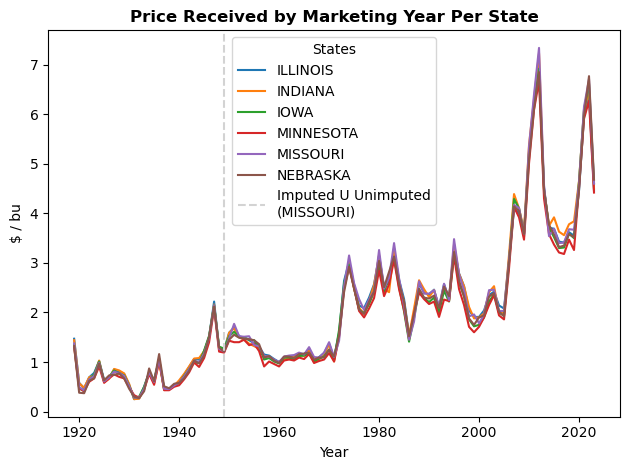

In [70]:
# visualizing the aforementioned imputations

for state in states:
    df_temp = df_1919_2023[df_1919_2023['state_name'] == state]
    plt.plot(
        df_temp['year'],
        df_temp['marketing_year'],
        label=state
    )
plt.axvline(
    1949,
    color='lightgray',
    linestyle='--',
    label='Imputed U Unimputed\n(MISSOURI)'
)
plt.legend(title='States')
plt.title('Price Received by Marketing Year Per State', fontweight='bold')
plt.ylabel('$ / bu')
plt.xlabel('Year')
plt.tight_layout()
plt.savefig('../../results/cleaning/preceived_marketing_year_plot.png') # file path appears as `results/cleaning/preceived_marketing_year_plot.png` in `cleaning.py`

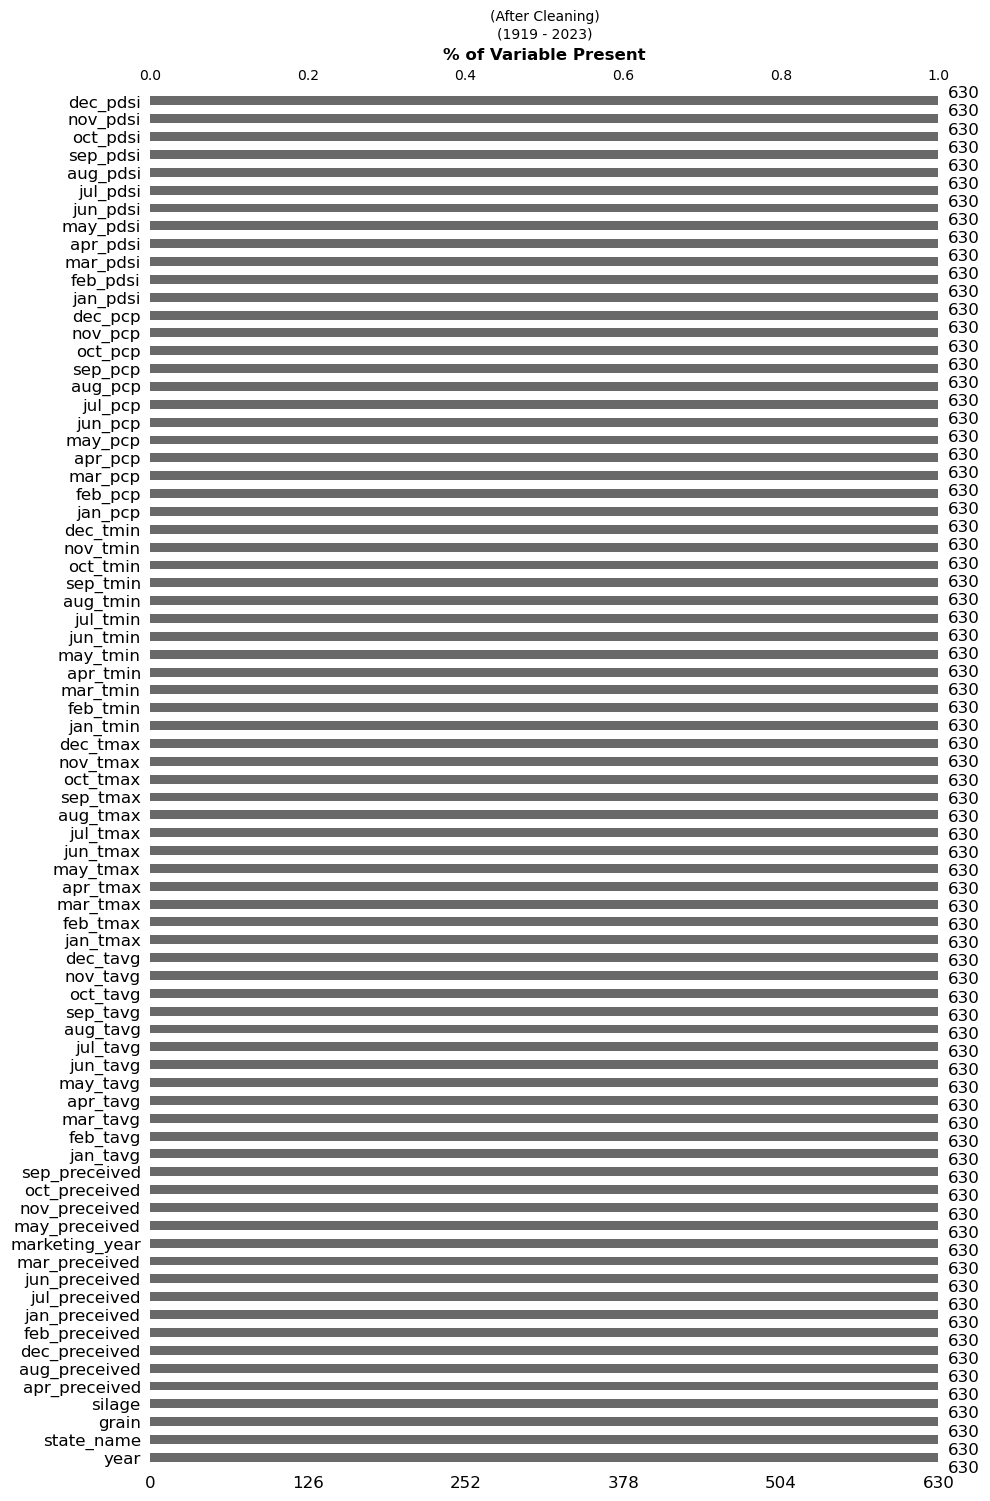

In [71]:
# visualizing the percentage of each variable that is *NOT* NaN after data cleaning

msno.bar(
    df_1919_2023,
    figsize=(10, 15),
    fontsize=12
)
plt.title('% of Variable Present', fontweight='bold')
plt.text(
    0.5, 80.5,
    f'(After Cleaning)',
    horizontalalignment='center'
)
plt.text(
    0.5, 79.5,
    f'(1919 - 2023)',
    horizontalalignment='center'
)
plt.tight_layout()
plt.savefig(
    f'../../results/cleaning/clean_msno_bar.png' # file path appears as `results/cleaning/clean_msno_bar.png` in `cleaning.py`
)
plt.show()

## Effects on the Data

Text(0.5, 0.98, 'Comparing `marketing_year` for MISSOURI Pre- and Post-cleaning')

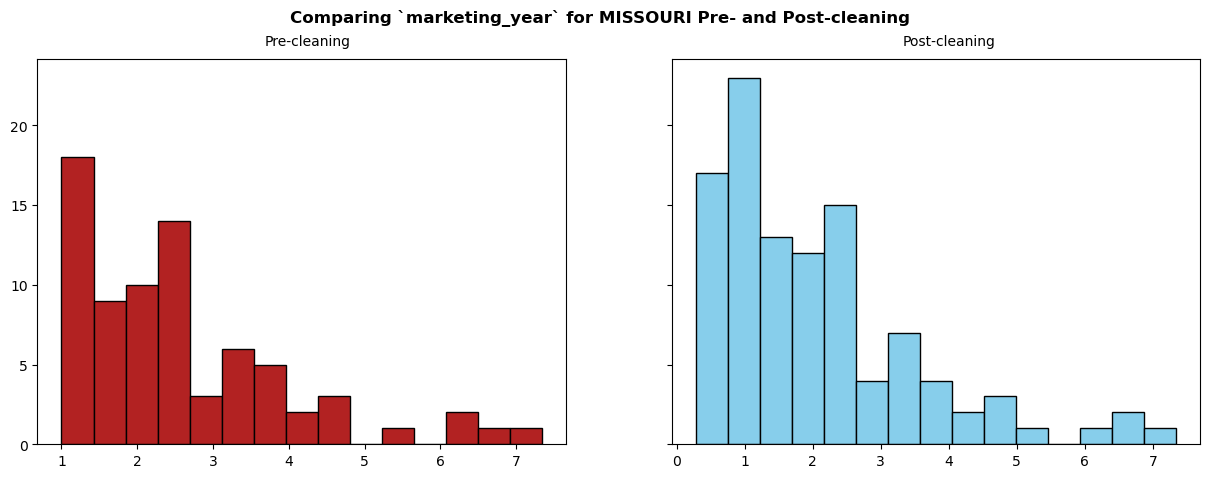

In [72]:
# visualizing the change in distribution of `marketing_year` for MISSOURI due to imputations

fig, axes = plt.subplots(
    1, 2,
    figsize=(15, 5),
    sharey=True
)

axes[0].hist(
    x=df_1866_2024[df_1866_2024['state_name'] == 'MISSOURI']['marketing_year'],
    bins=15,
    color='firebrick',
    edgecolor='black'
)
axes[0].text(
    4.25, 25,
    horizontalalignment='center',
    s='Pre-cleaning'
)

axes[1].hist(
    x=df_1919_2023[df_1919_2023['state_name'] == 'MISSOURI']['marketing_year'],
    bins=15,
    color='skyblue',
    edgecolor='black'
)
axes[1].text(
    4, 25,
    horizontalalignment='center',
    s='Post-cleaning'
)

fig.suptitle('Comparing `marketing_year` for MISSOURI Pre- and Post-cleaning', fontweight='bold')
fig.savefig('../../results/cleaning/marketing_year_hist.png') # file path appears as `results/cleaning/marketing_year_hist.png` in `cleaning.py`

In [75]:
## calculating whether the differences observed in the distributions is due to randomness or is significant

pre_cleaning_preceived = df_1866_2024[df_1866_2024['state_name'] == 'MISSOURI']['marketing_year']
post_cleaning_preceived = df_1919_2023[df_1919_2023['state_name'] == 'MISSOURI']['marketing_year']

statistic, pvalue = ks_2samp(pre_cleaning_preceived, post_cleaning_preceived, nan_policy='omit')
print(f'Reject null. pvalue={round(pvalue, 4)}, significance level=0.05') if pvalue<0.05 else print(f'Fail to reject null. pvalue={round(pvalue, 4)}, significance level=0.05')

Reject null. pvalue=0.016, significance level=0.05


In [271]:
# save the dataframe as a local CSV

df_1919_2023.to_csv('../../data/clean/clean.csv', index=False) # file path appears as `data/clean/clean.csv` in `cleaning.py`